# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

In [205]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets import FakeData, CIFAR10, CIFAR100
import torchvision.transforms as transforms
from torch.utils.data import Subset

# Select gpu if available.
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
N_EXAMPLES = 5  # Number of examples to visualize.
BATCH_SIZE = 32  # Mini-batch size for dataloader.

NORM_MEAN = np.array([0.5, 0.5, 0.5])
NORM_STD = np.array([0.5, 0.5, 0.5])


# functions to show an image
def imshow(img, normalized=True):
    npimg = img.cpu().permute(1, 2, 0).numpy()
    if normalized:
        npimg = (npimg * NORM_STD[None,None]) + NORM_MEAN[None,None]
    npimg = np.clip(npimg, a_min=0.0, a_max=1.0)
    plt.imshow(npimg)

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        imshow(images[idx].cpu())
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            ID_CLASSES[preds[idx]],
            probs[idx] * 100.0,
            ID_CLASSES[labels[idx]]),
            color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig



### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).

**Note**: Make sure you make a validation split of your ID dataset for testing.

In [206]:
# We will use CIFAR-10 as our in-distribution dataset.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the datasets and setup the DataLoaders.
ds_train = CIFAR10(root='./data', train=True, download=True, transform=transform)
# Split train into train and validation.
# val_size = int(0.1 * len(cifar_train))
# I = np.random.permutation(len(cifar_train))
# ds_train = SubsetDataset(Subset(cifar_train, I[val_size:]), transform)
# ds_val = SubsetDataset(Subset(cifar_train, I[:val_size]), transform)

ds_test = CIFAR10(root='./data', train=False, download=True, transform=transform)

dl_train = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
# dl_val = torch.utils.data.DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# In case we want to pretty-print classifications.
ID_CLASSES = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


torch.Size([32, 3, 32, 32]) torch.Size([32])
  dog truck   car  frog truck


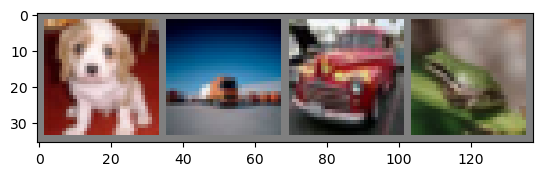

In [207]:
images,labels = next(iter(dl_train))
print(images.shape, labels.shape)
# show images
imshow(torchvision.utils.make_grid(images[0:4]))
print(' '.join('%5s' % ID_CLASSES[labels[j]] for j in range(N_EXAMPLES)))

#### CIFAR-100 Subset
For the OOD dataset, we select a subset of CIFAR-100 dataset. Even if CIFAR-100 classes are disjoint from CIFAR-10, some classes may be similar or equivalent to their CIFAR-10 counterpart (e.g "streetcar" and "car", "truck" and "pickup truck", "dog" or "cat" and "fox" ...). 

Therefore, we selected only classes describing "humans" classes from CIFAR-100, which are not present in CIFAR-10. This should make the OOD detection easier (and more meaningful) than using the full dataset.

In [208]:
# Fake dataset.
ds_fake = CIFAR100(root='./data', train=True, download=True, transform=transform)

# Subset of CIFAR-100 describing humans
OOD_CLASSES = ['baby','boy','girl','man','woman']
OOD_CLASSES_IDX = {c:ds_fake.class_to_idx[c] for c in OOD_CLASSES}
OOD_IDX_CLASSES = {v:k for k,v in OOD_CLASSES_IDX.items()}
indices_to_select = [i for i in range(len(ds_fake)) if ds_fake.targets[i] in OOD_CLASSES_IDX.values()]

ds_fake = Subset(ds_fake,indices_to_select)
dl_fake = torch.utils.data.DataLoader(ds_fake, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified


torch.Size([32, 3, 32, 32]) torch.Size([32])
  boy   boy   boy woman


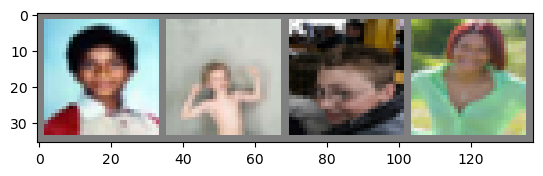

In [209]:
images,labels = next(iter(dl_fake))
print(images.shape, labels.shape)
# show images
imshow(torchvision.utils.make_grid(images[0:4]))
print(' '.join('%5s' % OOD_IDX_CLASSES[labels[j].item()] for j in range(4)))

In [210]:
# A very simple CNN model.
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [211]:
# USE THIS CELL TO LOAD THE PRETRAINED MODEL.
model = CNN().to(DEVICE)
model.load_state_dict(torch.load('./cifar10_CNN.pth'))

model.eval()

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [212]:
from tqdm import tqdm

# Function to collect all logits from the model on entire dataset.
def collect_logits(model, dl):
    logits = []
    with torch.no_grad():
        for (Xs, _) in tqdm(dl):
            logits.append(model(Xs.to(DEVICE)).cpu().numpy())
    return np.vstack(logits)

In [213]:
# Collect logits on CIFAR-10 test set (ID) and noise (very OOD).
logits_ID = collect_logits(model, dl_test)
logits_OOD = collect_logits(model, dl_fake)

100%|██████████| 79/79 [00:07<00:00, 10.82it/s]


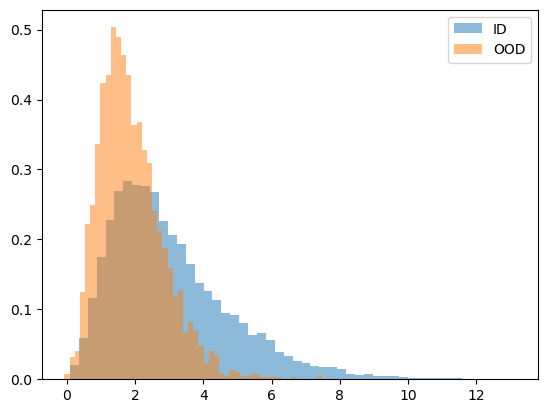

In [214]:
# Plot the *distribution* of max logit outputs.
_ = plt.hist(logits_ID.max(1), 50, density=True, alpha=0.5, label='ID')
_ = plt.hist(logits_OOD.max(1), 50, density=True, alpha=0.5, label='OOD')
plt.legend()

Instead of just using the maximum logit output, we can rescale the distribution with a temperature-scaled softmax. This is done by using a temperature parameter $T$ to "soften" the logits before applying the softmax function. The softmax function is defined as:

$$P(y=y_i) = \frac{e^\frac{y_i}{T}}{\sum_{k=1}^n e^\frac{y_k}{T}}$$

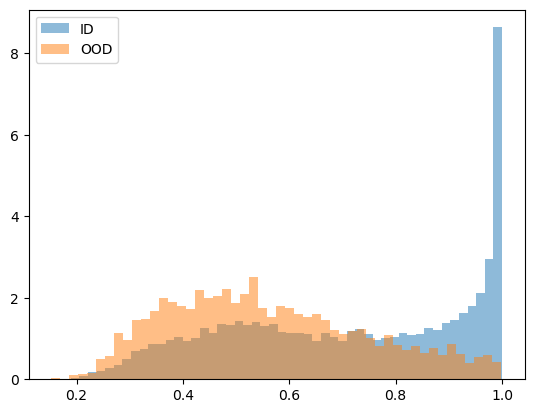

In [215]:
t = 0.7

probs_ID = F.softmax(torch.tensor(logits_ID/t), dim=1).numpy()
probs_OOD = F.softmax(torch.tensor(logits_OOD/t), dim=1).numpy()

# Plot the *distribution* of max logit outputs.
_ = plt.hist(probs_ID.max(1), 50, density=True, alpha=0.5, label='ID')
_ = plt.hist(probs_OOD.max(1), 50, density=True, alpha=0.5, label='OOD')
plt.legend()

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)

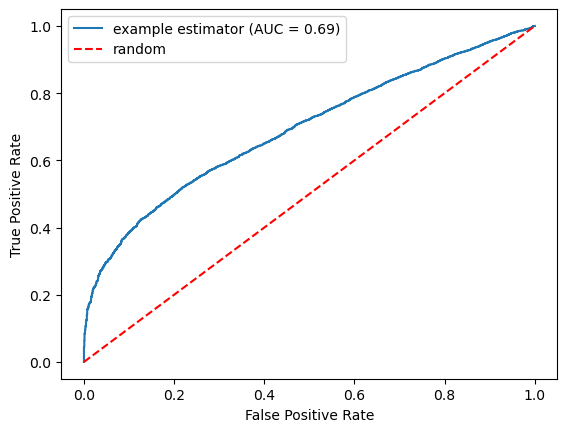

In [216]:
from sklearn.metrics import RocCurveDisplay, roc_curve,auc, PrecisionRecallDisplay

labels = np.hstack([np.ones_like(probs_ID.max(1)), np.zeros_like(probs_OOD.max(1))])



probs = np.hstack([probs_ID.max(1), probs_OOD.max(1)])

fpr, tpr, thresholds = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='example estimator')
display.plot()
# add random line
plt.plot([0, 1], [0, 1], color='red', linestyle='--',label='random')
plt.legend()
plt.show()

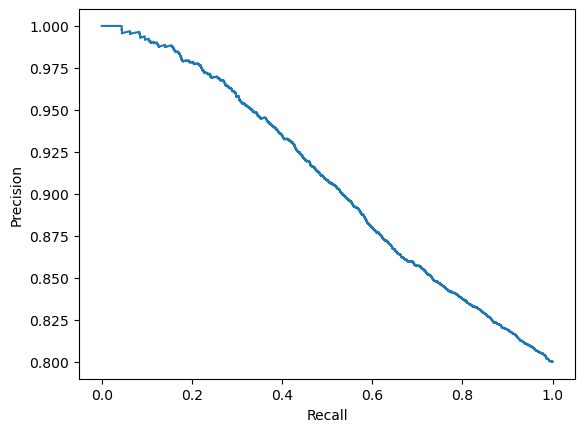

In [217]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(labels, probs)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

plt.show()

---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks. 

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are. 

In [218]:
def fgsm(Xs, grad, eps=0.1):
    sign_data_grad = grad.sign()
    perturbed_image = Xs + eps*sign_data_grad
    # try normalization instead of clamping
    # perturbed_image = torch.clamp(perturbed_image, 0., 1.)
    return perturbed_image.detach(), sign_data_grad.detach()

def attack(model, Xs, ys, eps=0.1):
    # Watch out! Uses original image
    Xs.requires_grad = True
    logits = model(Xs)
    init_pred = logits.max(1, keepdim=True)[1]
    # If the initial prediction is wrong, attack and gradient could be wrong?
    loss = F.cross_entropy(logits, ys)
    model.zero_grad()
    loss.backward()
    image_grad = Xs.grad.data
    # mask = torch.nonzero((init_pred != ys).int())
    # image_grad[mask] = torch.zeros(image_grad[mask].shape[1:])
    # print(image_grad.shape)
    Xs_adv, _ = fgsm(Xs, image_grad, eps)
    # Xs_adv = transforms.Normalize(NORM_MEAN, NORM_STD)(Xs_adv)
    # Re-classify the perturbed image
    output = model(Xs_adv)

    # Check for success
    final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    return Xs_adv.detach(), final_pred

def test_adversarial( model, device, test_loader, epsilon ):
    # Accuracy counter
    correct = 0
    adv_examples = None

    # Loop over all examples in test set
    for i,(Xs, ys) in enumerate(test_loader):
        Xs, ys = Xs.to(device), ys.to(device)
        Xs_adversarial_normalized, final_pred =  attack(model, Xs, ys, epsilon)
        correct += (final_pred.squeeze() == ys).sum().item()
        # add first batch of adversarial examples
        if i==0:
            adv_ex = Xs_adversarial_normalized.detach().cpu().numpy()
            adv_examples = (adv_ex, ys, final_pred)

    # Calculate final accuracy for this epsilon
    acc = correct/float(len(test_loader) * BATCH_SIZE)
    print(f"Epsilon: {epsilon:.2f}\tTest Accuracy = {correct} / {len(test_loader) * BATCH_SIZE} = {acc}")

    # Return the accuracy and an adversarial example
    return acc, adv_examples



We will use the pretrained model, provided along with the notebook during the flipped lesson. The pretrained model reaches 62% accuracy on the CIFAR-10 test set.
Here are a few prediction examples:  

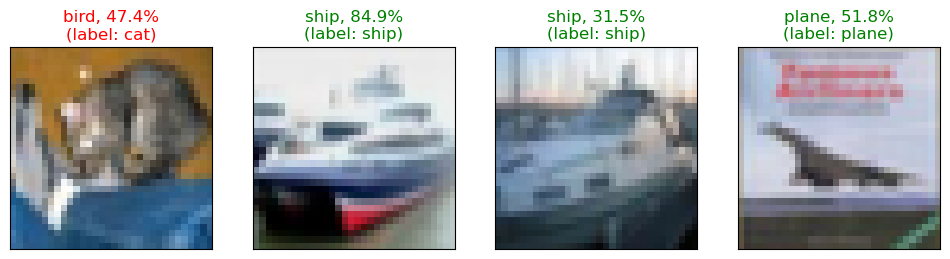

In [219]:
images,labels = next(iter(dl_test))
fig = plot_classes_preds(model.to(DEVICE), images.to(DEVICE), labels)

We will now execute the FGSM attack on a single sample, and show the original and perturbed images side-by-side, along with the perturbation itself.

init pred: ship
final pred: car


Text(0.5, 1.0, 'gradient sign')

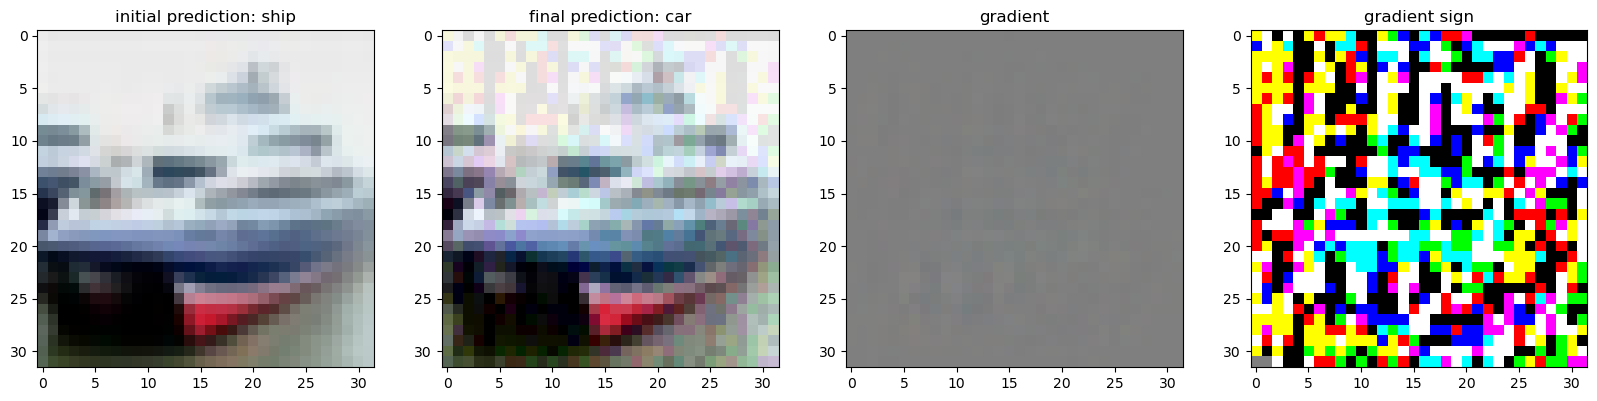

In [220]:
images, labels = next(iter(dl_test))
x, y = images[1], labels[1]

x = x.unsqueeze(0).to(DEVICE)
x.requires_grad = True
logits = model(x)
init_pred = torch.argmax(logits, dim=1)
print(f"init pred: {ID_CLASSES[init_pred]}")
# If the initial prediction is wrong, attack and gradient could be wrong?
loss = F.cross_entropy(logits, y.unsqueeze(0).to(DEVICE))
model.zero_grad()
loss.backward()
image_grad = x.grad.data
# mask = torch.nonzero((init_pred != ys).int())
# image_grad[mask] = torch.zeros(image_grad[mask].shape[1:])
# print(image_grad.shape)
x_perturbed, grad_sign = fgsm(x, image_grad, 0.1)
# Xs_adv = transforms.Normalize(NORM_MEAN, NORM_STD)(Xs_adv)
# Re-classify the perturbed image
output = model(x_perturbed)

# Check for success
final_pred = torch.argmax(output, dim=1).detach() # get the index of the max log-probability
print(f"final pred: {ID_CLASSES[final_pred]}")

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 4, 1)
imshow(x.detach().squeeze())
ax.set_title(f"initial prediction: {ID_CLASSES[init_pred]}")
ax = fig.add_subplot(1, 4, 2)
imshow(x_perturbed.detach().squeeze())
ax.set_title(f"final prediction: {ID_CLASSES[final_pred]}")
ax = fig.add_subplot(1, 4, 3)
imshow(image_grad.detach().squeeze())
ax.set_title("gradient")
ax = fig.add_subplot(1, 4, 4)
imshow(grad_sign.detach().squeeze())
ax.set_title("gradient sign")

To verify if the attack was successful, we try to predict the class of the perturbed images. As we can see, all images are now misclassified.

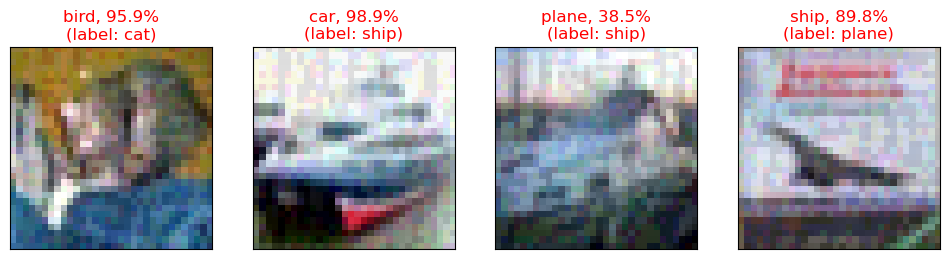

In [221]:
images,labels = next(iter(dl_test))
adv = attack(model.cpu(), images, labels, eps=0.1)

logits = model(adv[0])
preds = logits.max(1, keepdim=True)[1]

fig = plot_classes_preds(model.cpu(), adv[0], labels)

In [222]:
N_EXAMPLES = 5
model = model.to(DEVICE)

accuracies = []
examples = []

epsilons = np.arange(0, 0.3, 0.05)

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test_adversarial(model, DEVICE, dl_test, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0.00	Test Accuracy = 6036 / 10016 = 0.6026357827476039
Epsilon: 0.05	Test Accuracy = 748 / 10016 = 0.07468051118210862
Epsilon: 0.10	Test Accuracy = 134 / 10016 = 0.013378594249201278
Epsilon: 0.15	Test Accuracy = 60 / 10016 = 0.0059904153354632585
Epsilon: 0.20	Test Accuracy = 55 / 10016 = 0.005491214057507987
Epsilon: 0.25	Test Accuracy = 63 / 10016 = 0.006289936102236422


As we can see from the plot, the accuracy drops from 60% to less than 10% (which is equivalent to random choice on CIFAR-10) even with the smaller perturbation, thus the adversarial attacks are very effective on our model.

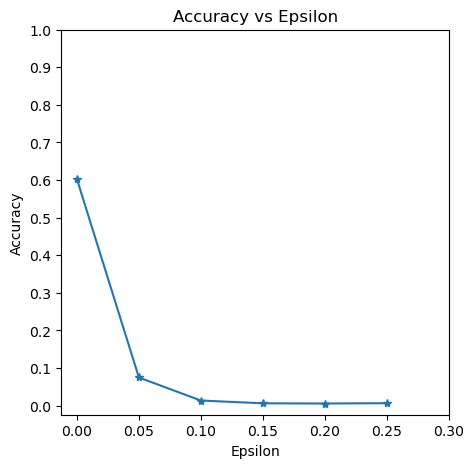

In [223]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-", label="standard model")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

We know that the FGSM attack is very effective, but the image quality degrades quickly when using a higher $\epsilon$. At $\varepsilon= 0.1$ the perturbation is clearly visible, and at $\varepsilon=0.25$ the image is almost unrecognizable. 

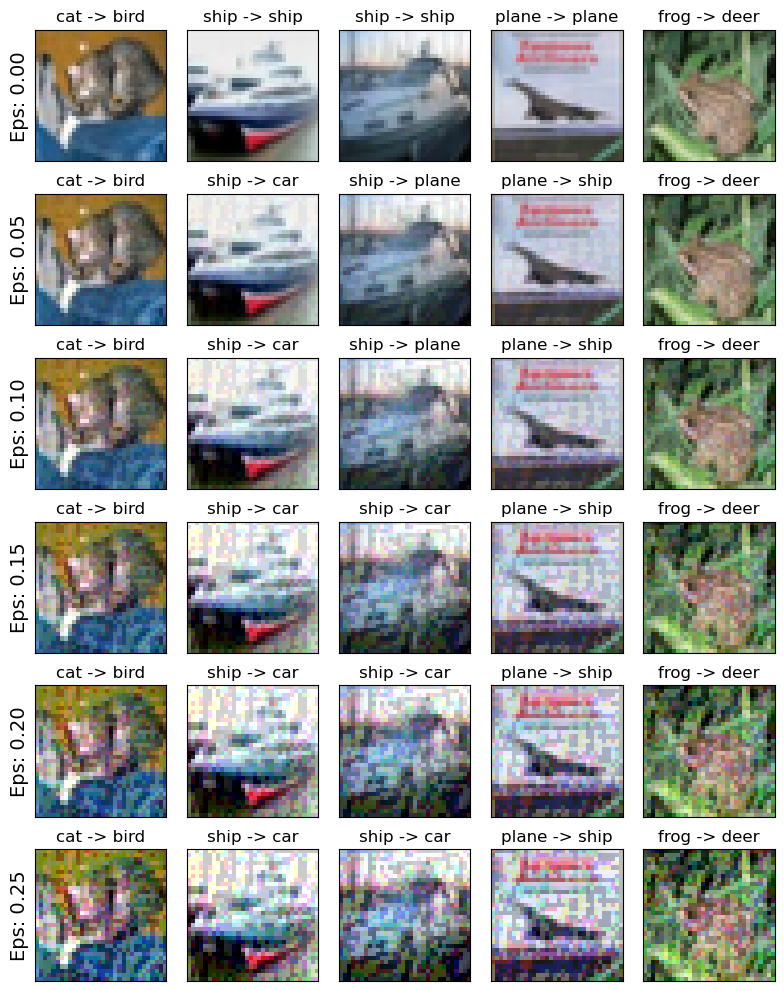

In [224]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    ex, orig, adv = examples[i]
    for j in range(0,N_EXAMPLES):
        cnt += 1
        plt.subplot(len(epsilons),N_EXAMPLES,cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]:.2f}", fontsize=14)
        plt.title(f"{ID_CLASSES[orig[j]]} -> {ID_CLASSES[adv[j]]}")
        imshow(torch.from_numpy(ex[j]),normalized=True)
plt.tight_layout()
plt.show()

### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

In [225]:
def train_epoch(model, optimizer, device, train_loader, val_loader, epsilon ):
    # Accuracy counter
    correct = 0
    adv_examples = []
    losses = []
    # Loop over all examples in test set
    for Xs, ys in train_loader:
        Xs, ys = Xs.to(device), ys.to(device)
        Xs_adversarial_normalized, _ = attack(model, Xs, ys, epsilon)
        logits = model(Xs_adversarial_normalized)
        loss = F.cross_entropy(logits, ys)
        losses.append(loss.item())
        # Gradients are already zeroed out by attack function.
        loss.backward()
        optimizer.step()
        preds = torch.argmax(logits, dim=1)
        correct += (preds.squeeze() == ys).sum().item()

    train_acc = correct/float(len(train_loader) * BATCH_SIZE)
    # Calculate validation accuracy for this epsilon
    valid_acc, _ = test_adversarial(model, device, val_loader, epsilon)

    # Return the accuracy and an adversarial example
    return train_acc, valid_acc, losses

In [226]:
from torch import optim
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(0,10):
    train_acc, valid_acc, losses = train_epoch(model, optimizer, DEVICE, dl_train, dl_test, epsilon=0.1)
    print(f"Epoch {epoch}:\tTrain Accuracy = {train_acc:.2f}\tValid Accuracy = {valid_acc:.2f}\tLoss = {np.mean(losses):.2f}")

Epsilon: 0.10	Test Accuracy = 1627 / 10016 = 0.16244009584664537
Epoch 0:	Train Accuracy = 0.13	Valid Accuracy = 0.16	Loss = 2.34
Epsilon: 0.10	Test Accuracy = 1835 / 10016 = 0.18320686900958466
Epoch 1:	Train Accuracy = 0.17	Valid Accuracy = 0.18	Loss = 2.20
Epsilon: 0.10	Test Accuracy = 1841 / 10016 = 0.183805910543131
Epoch 2:	Train Accuracy = 0.19	Valid Accuracy = 0.18	Loss = 2.16
Epsilon: 0.10	Test Accuracy = 1947 / 10016 = 0.19438897763578275
Epoch 3:	Train Accuracy = 0.20	Valid Accuracy = 0.19	Loss = 2.13
Epsilon: 0.10	Test Accuracy = 2420 / 10016 = 0.24161341853035143
Epoch 4:	Train Accuracy = 0.22	Valid Accuracy = 0.24	Loss = 2.08
Epsilon: 0.10	Test Accuracy = 2738 / 10016 = 0.27336261980830673
Epoch 5:	Train Accuracy = 0.27	Valid Accuracy = 0.27	Loss = 1.96
Epsilon: 0.10	Test Accuracy = 3056 / 10016 = 0.305111821086262
Epoch 6:	Train Accuracy = 0.30	Valid Accuracy = 0.31	Loss = 1.88
Epsilon: 0.10	Test Accuracy = 3309 / 10016 = 0.3303714057507987
Epoch 7:	Train Accuracy = 0.33

Epsilon: 0.00	Test Accuracy = 5938 / 10016 = 0.5928514376996805
Epsilon: 0.05	Test Accuracy = 3160 / 10016 = 0.31549520766773165
Epsilon: 0.10	Test Accuracy = 3847 / 10016 = 0.38408546325878595
Epsilon: 0.15	Test Accuracy = 3358 / 10016 = 0.3352635782747604
Epsilon: 0.20	Test Accuracy = 2899 / 10016 = 0.28943690095846647
Epsilon: 0.25	Test Accuracy = 2499 / 10016 = 0.24950079872204473


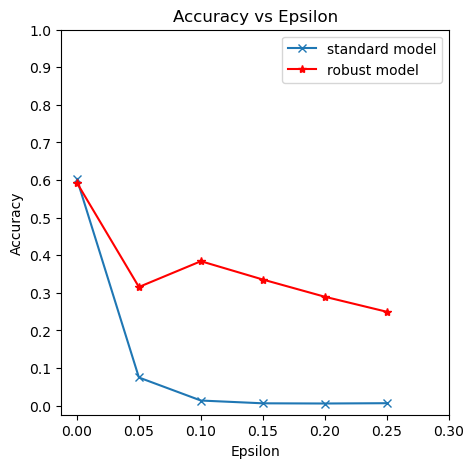

In [227]:
robust_accuracies = []
robust_examples = []

epsilons = np.arange(0, 0.3, 0.05)

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test_adversarial(model, DEVICE, dl_test, eps)
    robust_accuracies.append(acc)
    robust_examples.append(ex)

plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "x-", label="standard model")
plt.plot(epsilons, robust_accuracies, "*-", color="red", label="robust model")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

We can see that the model is more robust to adversarial attacks, reaching an accuracy of 30% on the adversarial samples. We can also see that the accuracy is higher at $\epsilon = 0.1$, which is the value used for perturbations during training. To produce models robust to a wider range of perturbation, we would need to train the model varying the value of $\epsilon$. 

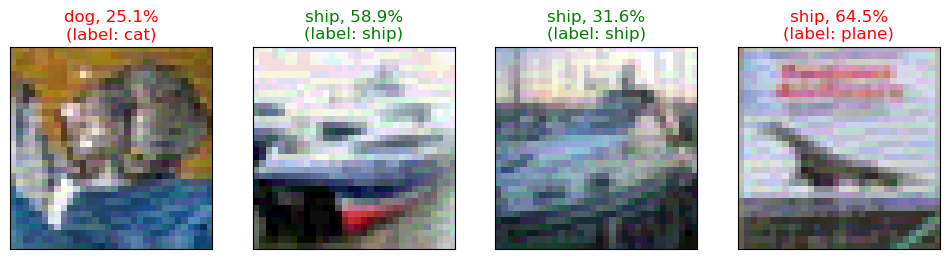

In [228]:
images,labels = next(iter(dl_test))
adv = attack(model.cpu(), images, labels, eps=0.1)

logits = model(adv[0])
preds = logits.max(1, keepdim=True)[1]

fig = plot_classes_preds(model.cpu(), adv[0], labels)

For this small sample, we can see that even with a quite strong perturbation, the FGSM attack is less effective. 
Let's also see the gradient and the gradient sign for a single example.

init pred: ship
final pred: ship


Text(0.5, 1.0, 'gradient sign')

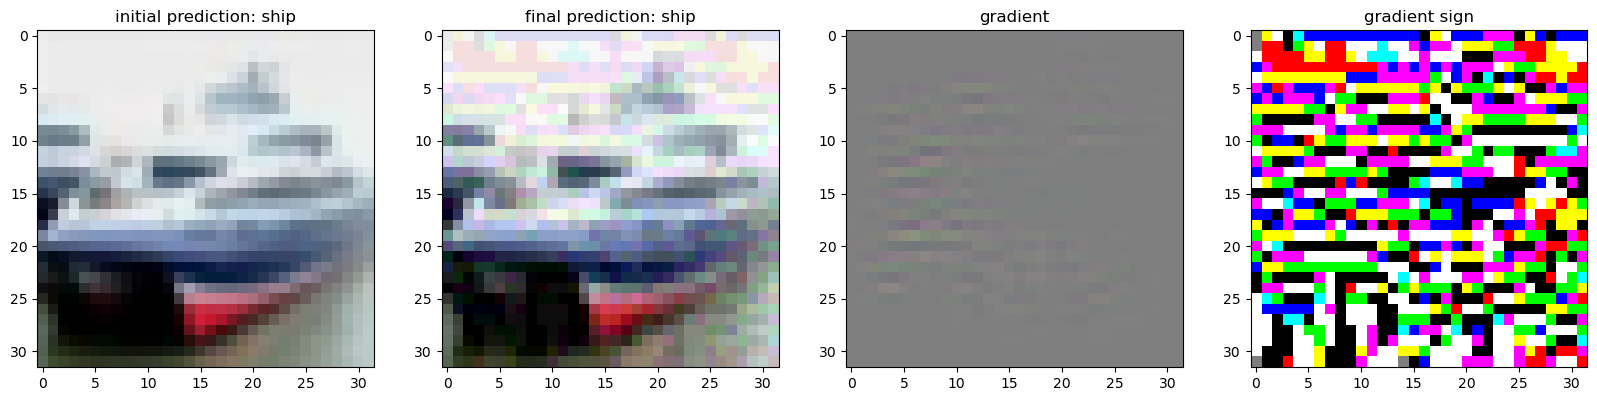

In [229]:
model.to(DEVICE)
images, labels = next(iter(dl_test))
x, y = images[1], labels[1]

x = x.unsqueeze(0).to(DEVICE)
x.requires_grad = True
logits = model(x)
init_pred = torch.argmax(logits, dim=1)
print(f"init pred: {ID_CLASSES[init_pred]}")
# If the initial prediction is wrong, attack and gradient could be wrong?
loss = F.cross_entropy(logits, y.unsqueeze(0).to(DEVICE))
model.zero_grad()
loss.backward()
image_grad = x.grad.data
# mask = torch.nonzero((init_pred != ys).int())
# image_grad[mask] = torch.zeros(image_grad[mask].shape[1:])
# print(image_grad.shape)
x_perturbed, grad_sign = fgsm(x, image_grad, 0.1)
# Xs_adv = transforms.Normalize(NORM_MEAN, NORM_STD)(Xs_adv)
# Re-classify the perturbed image
output = model(x_perturbed)

# Check for success
final_pred = torch.argmax(output, dim=1).detach() # get the index of the max log-probability
print(f"final pred: {ID_CLASSES[final_pred]}")

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 4, 1)
imshow(x.detach().squeeze())
ax.set_title(f"initial prediction: {ID_CLASSES[init_pred]}")
ax = fig.add_subplot(1, 4, 2)
imshow(x_perturbed.detach().squeeze())
ax.set_title(f"final prediction: {ID_CLASSES[final_pred]}")
ax = fig.add_subplot(1, 4, 3)
imshow(image_grad.detach().squeeze())
ax.set_title("gradient")
ax = fig.add_subplot(1, 4, 4)
imshow(grad_sign.detach().squeeze())
ax.set_title("gradient sign")

The jacobian of the image of the robust model is more salient than the jacobian of the original model.

#### Out-of Distribution Detection
Now that we have a model that is robust to adversarial attack, let's see if it is also more robust to OOD samples. We will use the same OOD detection pipeline as in Exercise 1.1.

In [230]:
# Collect logits on CIFAR-10 test set (ID) and noise (very OOD).
logits_ID = collect_logits(model, dl_test)
logits_OOD = collect_logits(model, dl_fake)

100%|██████████| 79/79 [00:07<00:00,  9.95it/s]


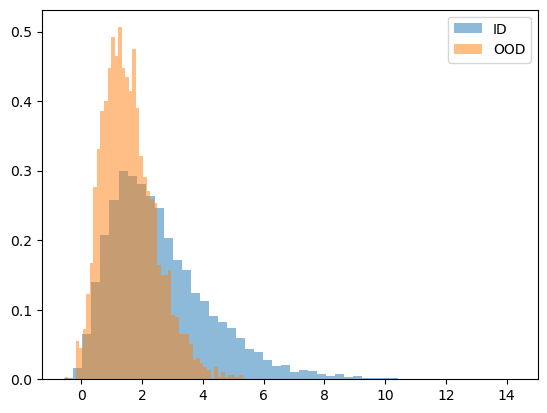

In [231]:
# Plot the *distribution* of max logit outputs.
_ = plt.hist(logits_ID.max(1), 50, density=True, alpha=0.5, label='ID')
_ = plt.hist(logits_OOD.max(1), 50, density=True, alpha=0.5, label='OOD')
plt.legend()

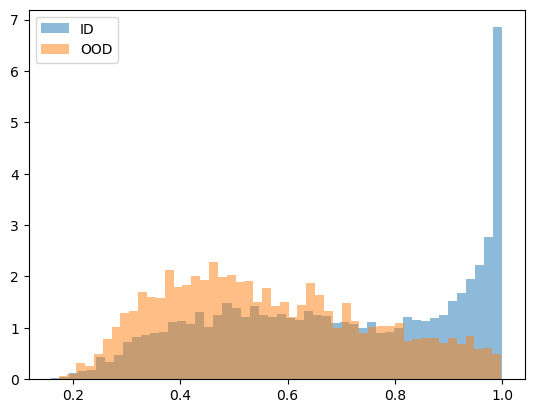

In [232]:
t = 0.7

probs_ID = F.softmax(torch.tensor(logits_ID/t), dim=1).numpy()
probs_OOD = F.softmax(torch.tensor(logits_OOD/t), dim=1).numpy()

# Plot the *distribution* of max probability outputs.

_ = plt.hist(probs_ID.max(1), 50, density=True, alpha=0.5, label='ID')
_ = plt.hist(probs_OOD.max(1), 50, density=True, alpha=0.5, label='OOD')
plt.legend()

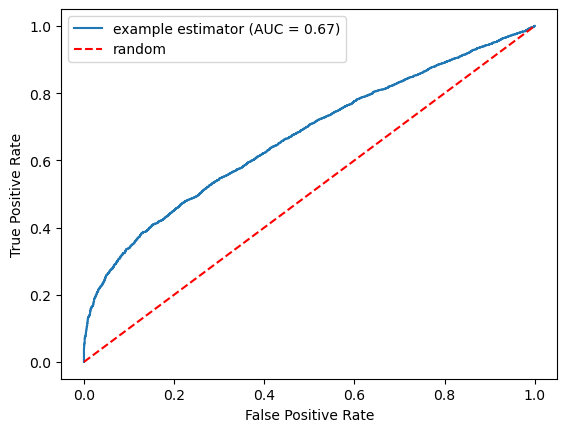

In [233]:
from sklearn.metrics import RocCurveDisplay, roc_curve,auc, PrecisionRecallDisplay

labels = np.hstack([np.ones_like(probs_ID.max(1)), np.zeros_like(probs_OOD.max(1))])



probs = np.hstack([probs_ID.max(1), probs_OOD.max(1)])

fpr, tpr, thresholds = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='example estimator')
display.plot()
# add random line
plt.plot([0, 1], [0, 1], color='red', linestyle='--',label='random')
plt.legend()
plt.show()

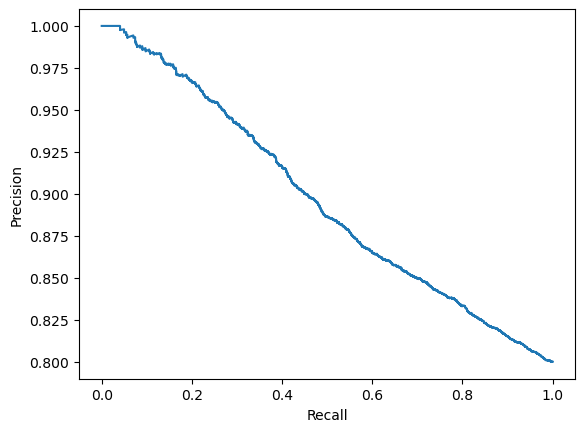

In [234]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(labels, probs)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

plt.show()

The ID samples result more salient, but still the OOD samples have high scores and are not easily distinguishable from ID samples.

---
## Exercise 3: Wildcard

You know the drill. Pick *ONE* of the following exercises to complete.

### Exercise 3.1: Implement ODIN for OOD detection
ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

### Exercise 3.2: Implement JARN
In exercise 2.2 you already implemented Jacobian-regularized learning to make your model more robust to adversarial samples. Add a *discriminator* to your model to encourage the adversarial samples used for regularization to be more *salient*.

See [the JARN paper](https://arxiv.org/abs/1912.10185) for more details.

### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.


### Exercise 3.2

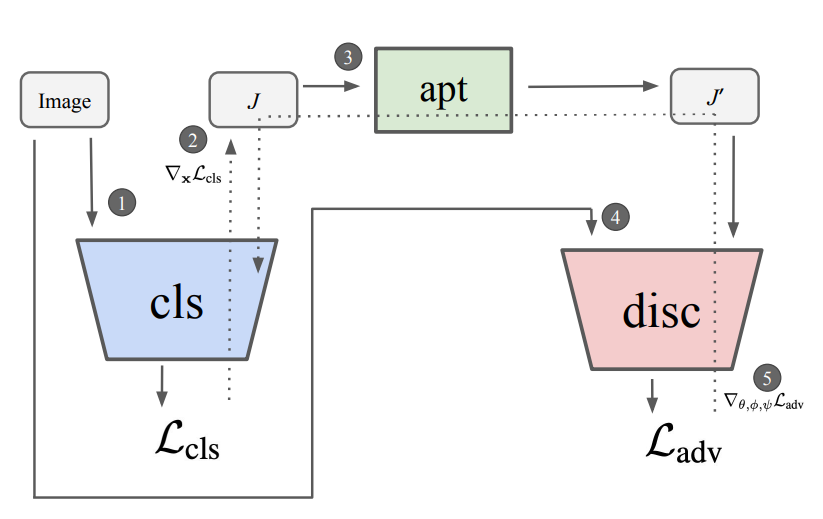

In [235]:
# A very simple CNN model.
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = x.squeeze()
        return x
    
class Generator(nn.Module):
    def __init__(self, classifier, eps, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.classifier = classifier
        self.eps = eps
        self.adaptor = nn.Sequential(
            nn.Conv2d(3, 3, 1),
            nn.Tanh()
        )
        
    def forward(self, x):
        x, y = x
        x.requires_grad = True
        ############################
        # (4) x = x + eps * U(0,1)
        ###########################
        x = x + torch.rand_like(x) * self.eps
        logits = self.classifier(x)
        ############################
        # (5) l_cls = - yT log(G(x))
        ###########################
        loss = F.cross_entropy(logits, y)
        ############################
        # (6) J = grad l_cls w.r.t. x
        ###########################
        J = torch.autograd.grad(loss, x)[0]
        ############################
        # (7) J_prime = A(J)
        ###########################
        J_prime = self.adaptor(J)
        return x, J_prime

In [236]:
import time
import torch.optim as optim

id_label = 1
ood_label = 0
nepochs = 10

lambda_ = 1.
eps = 8/255

netG = model
#netG = CNN().to(DEVICE)
#netG.load_state_dict(torch.load('./cifar10_CNN.pth'))
netG.train()

update_d_every_n_steps = 20
criterion = nn.BCELoss()
netD = Discriminator().to(DEVICE)
netD.train()

netA = nn.Sequential(
    nn.Conv2d(3, 3, 1),
    nn.Tanh()
).to(DEVICE)
netA.train()

optimizerG = optim.Adam(netG.parameters(), lr=1e-3)
optimizerA = optim.Adam(netA.parameters(), lr=1e-3)
optimizerD = optim.SGD(netD.parameters(), lr=1e-3)

loss_g, loss_d, d_fake, d_real = [],[],[],[]

for epoch in range(nepochs):
    cls_correct = 0
    for i, (data, labels) in enumerate(dl_train, 0):
        t_start = time.time()
        data = data.to(DEVICE)
        labels = labels.to(DEVICE)
        netG.zero_grad()
        ############################
        # (4) x = x + eps * U(0,1)
        ###########################
        x = data + torch.rand_like(data) * eps
        x.requires_grad = True # TODO: should be before adding noise?
        ############################
        # (5) l_cls = - yT log(G(x))
        ###########################
        cls_out = netG(x)
        preds = cls_out.argmax(1)
        cls_correct += (preds.squeeze() == labels).sum().item()
        l_cls = F.cross_entropy(cls_out, labels)
        l_cls.backward(retain_graph=True)
        ############################
        # (6) J = grad l_cls w.r.t. x
        ###########################
        J = x.grad.data
        ############################
        # (7) J_prime = A(J)
        ###########################
        J_prime = netA(J)
        ############################
        # (8) l_adv = log(D(x)) + log(1 - D(J_prime))
        ###########################
        # build batch with real and fake data
        label_r = torch.ones(x.shape[0]) 
        label_f = torch.zeros(J_prime.shape[0]) 
        batch = torch.cat( (x.detach(), J_prime.detach()))
        disc_labels =  torch.cat((label_r, label_f))
        # calculate adversarial loss
        det_out = netD(J_prime)
        l_adv = -torch.log(det_out.squeeze()).mean()
        D_G_z2 = det_out.mean().item()
        
        ############################
        # (9) Update classifier: minimize l_cls + lambda * l_adv
        ###########################
        netG.zero_grad()
        errG = l_cls + lambda_ * l_adv
        errG.backward(retain_graph=True)
        optimizerG.step()
        ############################
        # (10) Update adapter: minimize l_adv
        ###########################
        netA.zero_grad()
        l_adv.backward()
        optimizerA.step()
        ############################
        # (11) Update D network: maximize l_adv
        ###########################
        if i % update_d_every_n_steps == 0:
            netD.zero_grad()
            det_out = netD(batch)
            errD = criterion(det_out, disc_labels.to(DEVICE))
            errD.backward()
            optimizerD.step()

            D_x = det_out[0:BATCH_SIZE].mean().item()
            D_G_z1 = det_out[BATCH_SIZE:].mean().item()
        t_end = time.time()
        if i % 100 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f Loss_Adv: %.4f D(x): %.4f D(G(z)): %.4f / %.4f %.1f images/s'
                  % (epoch, nepochs, i, len(dl_train),
                     errD.item(), errG.item(), l_adv.item(), D_x, D_G_z1, D_G_z2, batch.shape[0]/(t_end-t_start)))

        if i % 100 == 0:
            loss_g.append(errG.item())
            loss_d.append(errD.item())
    acc = cls_correct/float(len(dl_train) * BATCH_SIZE)
    print('[%d/%d] Accuracy: %.4f' % (epoch, nepochs, acc))
    adv_acc, _ = test_adversarial(netG, DEVICE, dl_test, 0.05)
    print('[%d/%d] Adversarial Accuracy: %.4f' % (epoch, nepochs, adv_acc))

[0/10][0/1563] Loss_D: 0.6940 Loss_G: 1.9755 Loss_Adv: 0.6952 D(x): 0.4982 D(G(z)): 0.4990 / 0.4990 3234.4 images/s
[0/10][100/1563] Loss_D: 0.6950 Loss_G: 1.2260 Loss_Adv: 0.6943 D(x): 0.4976 D(G(z)): 0.4994 / 0.4994 4969.2 images/s
[0/10][200/1563] Loss_D: 0.6946 Loss_G: 1.2902 Loss_Adv: 0.6942 D(x): 0.4980 D(G(z)): 0.4995 / 0.4995 4917.0 images/s
[0/10][300/1563] Loss_D: 0.6944 Loss_G: 1.8833 Loss_Adv: 0.6942 D(x): 0.4982 D(G(z)): 0.4995 / 0.4995 4721.2 images/s
[0/10][400/1563] Loss_D: 0.6946 Loss_G: 2.0971 Loss_Adv: 0.6942 D(x): 0.4980 D(G(z)): 0.4995 / 0.4995 3736.9 images/s
[0/10][500/1563] Loss_D: 0.6946 Loss_G: 1.9011 Loss_Adv: 0.6942 D(x): 0.4980 D(G(z)): 0.4995 / 0.4995 4116.9 images/s
[0/10][600/1563] Loss_D: 0.6947 Loss_G: 1.7778 Loss_Adv: 0.6942 D(x): 0.4979 D(G(z)): 0.4995 / 0.4995 4095.7 images/s
[0/10][700/1563] Loss_D: 0.6942 Loss_G: 1.6231 Loss_Adv: 0.6942 D(x): 0.4984 D(G(z)): 0.4995 / 0.4995 4735.5 images/s
[0/10][800/1563] Loss_D: 0.6944 Loss_G: 2.0435 Loss_Adv: 0

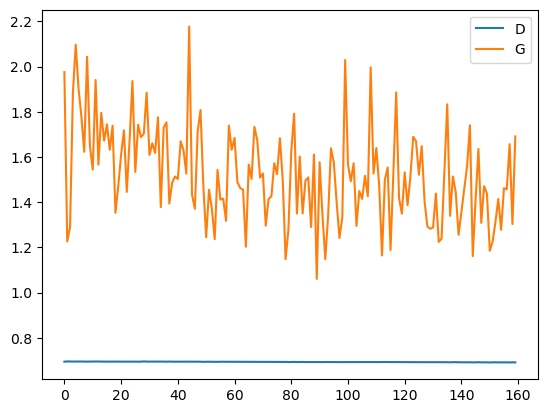

In [237]:
#Plot the loss
plt.plot(loss_d, label='D')
plt.plot(loss_g, label='G')
plt.legend()

min x: -0.9999682307243347| max x: 1.031362533569336 | min J_prime: -0.5178540945053101 | max J_prime: 0.9779757857322693


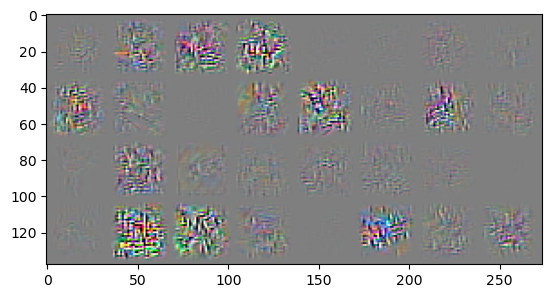

In [239]:
data, labels = next(iter(dl_train))
data, labels = data.to(DEVICE), labels.to(DEVICE)

x = data + torch.rand_like(data) * eps
x.requires_grad = True # TODO: should be before adding noise?
############################
# (5) l_cls = - yT log(G(x))
###########################
l_cls = F.cross_entropy(netG(x), labels.to(DEVICE))
l_cls.backward(retain_graph=True)
############################
# (6) J = grad l_cls w.r.t. x
###########################
J = x.grad.data
############################
# (7) J_prime = A(J)
###########################
J_prime = netA(J)

print(f'min x: {x.min()}| max x: {x.max()} | min J_prime: {J_prime.min()} | max J_prime: {J_prime.max()}')
imshow(torchvision.utils.make_grid(J.detach().cpu()*100))

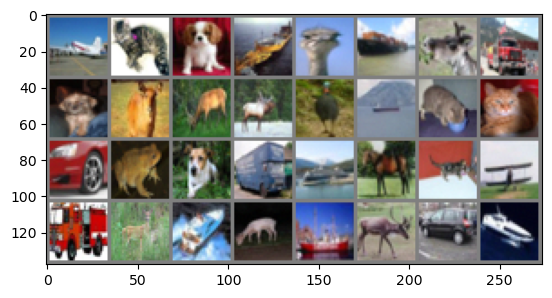

In [146]:
imshow(torchvision.utils.make_grid(x.detach().cpu()))

In [ ]:
label_r = torch.ones(x.shape[0]) 
label_f = torch.zeros(J_prime.shape[0]) 
batch = torch.cat( (x.detach(), J_prime.detach()))
disc_labels =  torch.cat((label_r, label_f))
# calculate adversarial loss
det_out = netD(batch)

In [240]:
import time
import torch.optim as optim

id_label = 1
ood_label = 0
nepochs = 10

lambda_ = 1.
eps = 8/255

netG = CNN().to(DEVICE)
netG.load_state_dict(torch.load('./cifar10_CNN.pth'))
netG.train()

update_d_every_n_steps = 20
criterion = nn.BCELoss()
netD = Discriminator().to(DEVICE)
netD.train()

netA = nn.Sequential(
    nn.Conv2d(3, 3, 1),
    nn.Tanh()
).to(DEVICE)

optimizerG = optim.Adam(netG.parameters(), lr=1e-3)
optimizerA = optim.Adam(netA.parameters(), lr=1e-3)
optimizerD = optim.SGD(netD.parameters(), lr=1e-3)

loss_g, loss_d, d_fake, d_real = [],[],[],[]

for epoch in range(nepochs):
    cls_correct = 0
    for i, (data, labels) in enumerate(dl_train, 0):
        t_start = time.time()
        data = data.to(DEVICE)
        labels = labels.to(DEVICE)
        netG.zero_grad()
        ############################
        # (4) x = x + eps * U(0,1)
        ###########################
        x = data + torch.rand_like(data) * eps
        x.requires_grad = True # TODO: should be before adding noise?
        ############################
        # (5) l_cls = - yT log(G(x))
        ###########################
        x_adv, _ = attack(netG, x, labels, eps)
        ############################
        # (6) J = grad l_cls w.r.t. x
        ###########################
        J = x.grad.data
        l_cls = F.cross_entropy(netG(x_adv), labels)
        l_cls.backward(retain_graph=True)
        ############################
        # (7) J_prime = A(J)
        ###########################
        J_prime = netA(J)
        ############################
        # (8) l_adv = log(D(x)) + log(1 - D(J_prime))
        ###########################
        # build batch with real and fake data
        label_r = torch.ones(x.shape[0]) 
        label_f = torch.zeros(J_prime.shape[0]) 
        batch = torch.cat( (x.detach(), J_prime.detach()))
        disc_labels =  torch.cat((label_r, label_f))
        # calculate adversarial loss
        det_out = netD(J_prime)
        l_adv = -torch.log(det_out.squeeze()).mean()
        D_G_z2 = det_out.mean().item()
        ############################
        # (9) Update classifier: minimize l_cls + lambda * l_adv
        ###########################
        netG.zero_grad()
        netA.zero_grad()
        errG = l_cls + lambda_ * l_adv
        errG.backward(retain_graph=True)
        optimizerG.step()
        optimizerA.step()
        ############################
        # (11) Update D network: maximize l_adv
        ###########################
        if i % update_d_every_n_steps == 0:
            netD.zero_grad()
            det_out = netD(batch)
            errD = criterion(det_out, disc_labels.to(DEVICE))
            errD.backward()
            optimizerD.step()

            D_x = det_out[0:BATCH_SIZE].mean().item()
            D_G_z1 = det_out[BATCH_SIZE:].mean().item()
        t_end = time.time()
        if i % 100 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f Loss_Adv: %.4f D(x): %.4f D(G(z)): %.4f / %.4f %.1f images/s'
                  % (epoch, nepochs, i, len(dl_train),
                     errD.item(), errG.item(), l_adv.item(), D_x, D_G_z1, D_G_z2, batch.shape[0]/(t_end-t_start)))

        if i % 100 == 0:
            loss_g.append(errG.item())
            loss_d.append(errD.item())
    acc = cls_correct/float(len(dl_train) * BATCH_SIZE)
    print('[%d/%d] Accuracy: %.4f' % (epoch, nepochs, acc))
    adv_acc, _ = test_adversarial(netG, DEVICE, dl_test, eps)
    print('[%d/%d] Adversarial Accuracy: %.4f' % (epoch, nepochs, adv_acc))

[0/10][0/1563] Loss_D: 0.6944 Loss_G: 3.0824 Loss_Adv: 0.6206 D(x): 0.5393 D(G(z)): 0.5376 / 0.5376 1797.0 images/s
[0/10][100/1563] Loss_D: 0.6947 Loss_G: 2.5241 Loss_Adv: 0.6199 D(x): 0.5394 D(G(z)): 0.5380 / 0.5380 4734.7 images/s
[0/10][200/1563] Loss_D: 0.6953 Loss_G: 2.7793 Loss_Adv: 0.6194 D(x): 0.5391 D(G(z)): 0.5383 / 0.5383 3965.8 images/s
[0/10][300/1563] Loss_D: 0.6954 Loss_G: 2.6237 Loss_Adv: 0.6191 D(x): 0.5391 D(G(z)): 0.5384 / 0.5384 3751.6 images/s
[0/10][400/1563] Loss_D: 0.6956 Loss_G: 2.4643 Loss_Adv: 0.6190 D(x): 0.5391 D(G(z)): 0.5385 / 0.5385 4408.2 images/s
[0/10][500/1563] Loss_D: 0.6957 Loss_G: 2.4642 Loss_Adv: 0.6189 D(x): 0.5391 D(G(z)): 0.5385 / 0.5385 4183.3 images/s
[0/10][600/1563] Loss_D: 0.6960 Loss_G: 2.3851 Loss_Adv: 0.6188 D(x): 0.5387 D(G(z)): 0.5386 / 0.5386 2937.4 images/s
[0/10][700/1563] Loss_D: 0.6957 Loss_G: 2.3284 Loss_Adv: 0.6188 D(x): 0.5390 D(G(z)): 0.5386 / 0.5386 3977.3 images/s
[0/10][800/1563] Loss_D: 0.6959 Loss_G: 2.9674 Loss_Adv: 0